In [1]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Mounted at /gdrive/
/gdrive


In [2]:
ls

MyDrive/  Shareddrives/


In [3]:
cd/gdrive/MyDrive/Thanos_VS_Grimace/

/gdrive/MyDrive/Thanos_VS_Grimace


In [4]:
ls

grimace/  thanos/


In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [6]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [7]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=20
CHANNELS=3

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/gdrive/MyDrive/Thanos_VS_Grimace",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 457 files belonging to 2 classes.


In [9]:
class_names = dataset.class_names
class_names

['grimace', 'thanos']

In [10]:
len(dataset)

8

In [11]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[231.      247.      234.     ]
  [233.45508 249.45508 236.45508]
  [236.0918  253.48633 239.78906]
  ...
  [251.78906 253.30273 252.0918 ]
  [246.82031 252.72852 247.82031]
  [237.      247.      238.     ]]

 [[231.81836 247.81836 234.81836]
  [233.60373 249.60373 236.60373]
  [237.23303 253.48633 240.35968]
  ...
  [252.28455 253.055   252.0918 ]
  [249.05162 252.95068 248.71219]
  [241.91016 251.91016 242.91016]]

 [[232.69727 250.0918  235.     ]
  [234.9046  251.72852 236.63672]
  [239.85321 254.11958 240.9725 ]
  ...
  [252.39453 253.      252.0918 ]
  [250.56009 253.2533  249.79672]
  [248.57812 254.39453 248.88086]]

 ...

 [[255.      255.      255.     ]
  [255.      255.      255.     ]
  [255.      255.      255.     ]
  ...
  [251.0918  252.60547 250.78906]
  [251.40009 252.91376 251.09735]
  [252.78906 254.30273 252.48633]]

 [[255.      255.      255.     ]
  [255.      255.      255.     ]
  [255.      255.      255.     ]
  ...
  [246.63

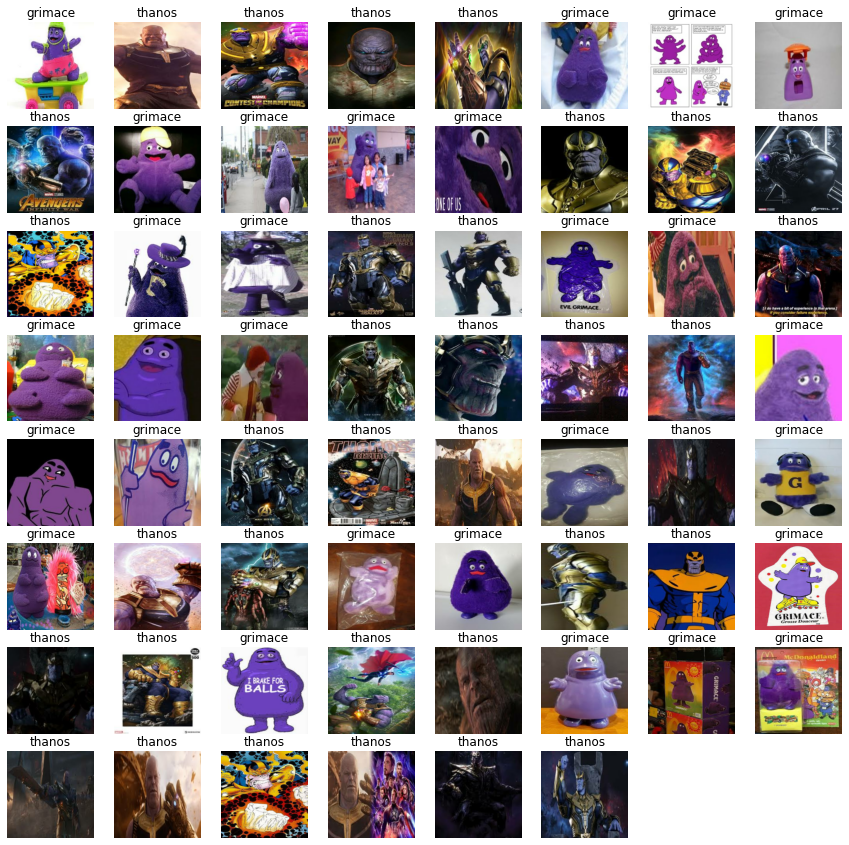

In [12]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (62, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (62, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (62, 60, 60, 64)         

In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
6/6 [==============================] - 38s 6s/step - loss: 1.2656 - accuracy: 0.4865
Epoch 2/20
6/6 [==============================] - 34s 6s/step - loss: 0.7479 - accuracy: 0.5435
Epoch 3/20
6/6 [==============================] - 34s 6s/step - loss: 0.6448 - accuracy: 0.6306
Epoch 4/20
6/6 [==============================] - 35s 6s/step - loss: 0.6275 - accuracy: 0.6276
Epoch 5/20
6/6 [==============================] - 36s 6s/step - loss: 0.5815 - accuracy: 0.6847
Epoch 6/20
6/6 [==============================] - 35s 6s/step - loss: 0.4963 - accuracy: 0.7477
Epoch 7/20
6/6 [==============================] - 35s 6s/step - loss: 0.4629 - accuracy: 0.7958
Epoch 8/20
6/6 [==============================] - 35s 6s/step - loss: 0.4195 - accuracy: 0.8108
Epoch 9/20
6/6 [==============================] - 35s 6s/step - loss: 0.3990 - accuracy: 0.8288
Epoch 10/20
6/6 [==============================] - 35s 6s/step - loss: 0.3464 - accuracy: 0.8589
Epoch 11/20
6/6 [======================

In [21]:
model.evaluate(test_ds)

2/2 [==============================] - 5s 2s/step - loss: 0.2301 - accuracy: 0.9274


[0.23008663952350616, 0.9274193644523621]

In [22]:
acc = history.history['accuracy']
loss = history.history['loss']

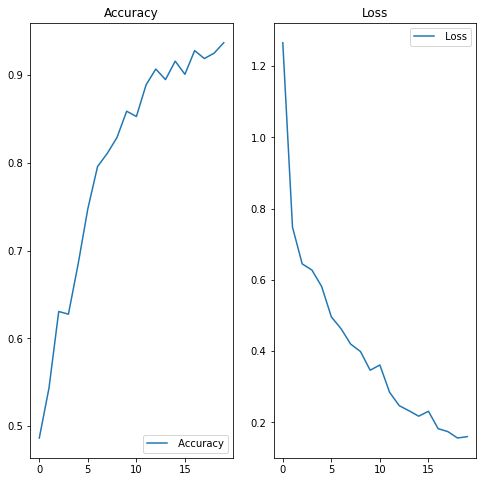

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

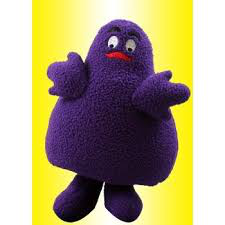

In [24]:
image_path = "/gdrive/My Drive/grimace_(203).jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [25]:
pred = model.predict(scaled_img)

In [26]:
output = class_names[np.argmax(pred)]

In [27]:
output

'grimace'

In [28]:
model.save("Thanos_VS_Grimace.h5")